In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence


C:\Users\Dario\AppData\Local\Temp\ipykernel_11248\4147300727.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ev = pd.read_csv('ia_data_events.csv')


array([[<Axes: title={'center': 'state'}>,
        <Axes: title={'center': 'isMoving'}>],
       [<Axes: title={'center': 'isPumpOn'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

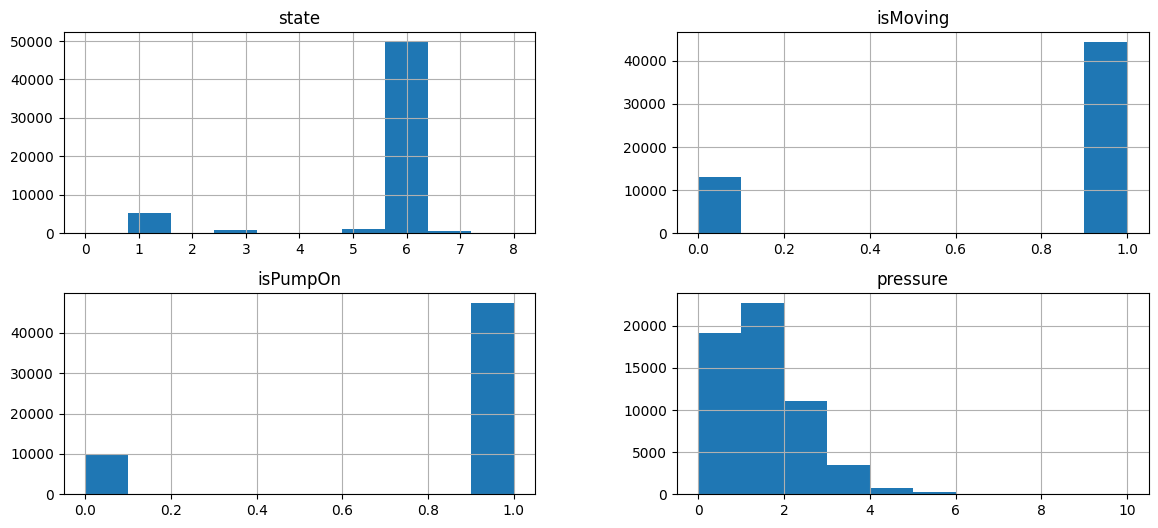

In [30]:
df_ev = pd.read_csv('ia_data_events.csv')
df_ev['isMoving'] = df_ev['isMoving'].astype(int)
df_ev['isPumpOn'] = df_ev['isPumpOn'].astype(int)
df_ev.hist(column=['state', 'isMoving', 'isPumpOn', 'pressure'], figsize=(14, 6))


array([[<Axes: title={'center': 'state'}>,
        <Axes: title={'center': 'isMoving'}>],
       [<Axes: title={'center': 'isPumpOn'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

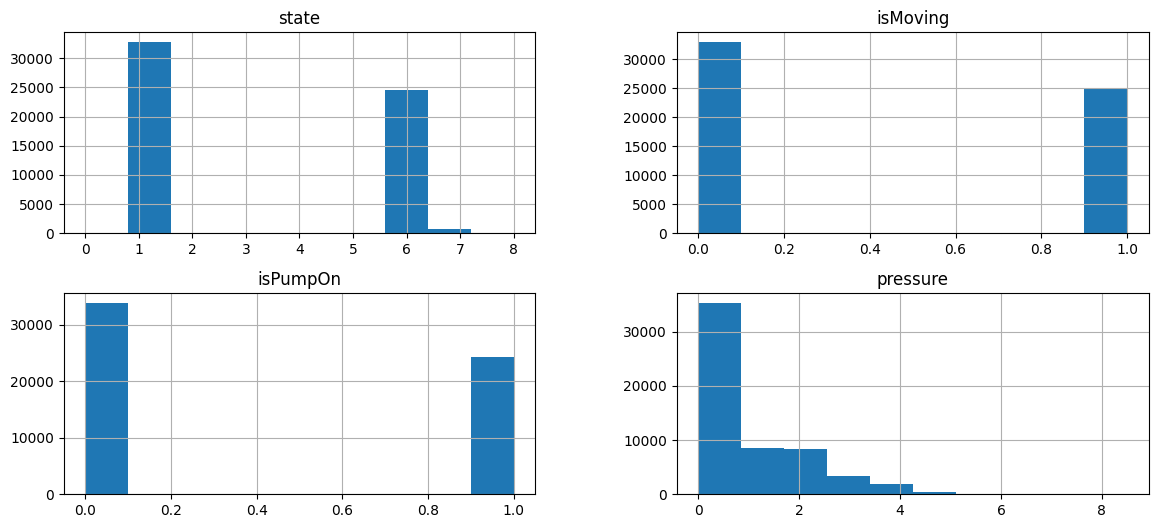

In [31]:
df_nf = pd.read_csv('ia_data_no_fails.csv')
df_nf['isMoving'] = df_nf['isMoving'].astype(int)
df_nf['isPumpOn'] = df_nf['isPumpOn'].astype(int)
df_nf.hist(column=['state', 'isMoving', 'isPumpOn', 'pressure'], figsize=(14, 6))

In [ ]:
ALARM_PUMP = 3
ALARM_EQUIPMENT = 5
OBS_HOURS = 6

def prepare_data (df):
  gb = df.groupby('intervalGroup')    
  train = []
  test = []
  for x in gb.groups:
    group = gb.get_group(x)
    group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
    group.loc[group.index[0], 'diffTime'] = 0
    x_group = group.drop(
      ['intervalGroup', 'timeToFail', 'deviceId', 'messageId', 'Time', 'rawSpeed'],
      axis=1
    )
    x_group['direction'] = x_group['direction'].apply(lambda x: 1 if x == 'F' else -1 if x == 'R' else 0)
    train.append(x_group.to_numpy())

    y_group = group[['timeToFail']].copy()
    last_state = x_group['state'].iloc[-1]
    y_group['pe'] = (last_state == ALARM_EQUIPMENT) and (y_group['timeToFail'] <= OBS_HOURS * 3600)
    y_group['pp'] = (last_state == ALARM_PUMP) and (y_group['timeToFail'] <= OBS_HOURS * 3600)
    y_group['pok'] = ~(y_group['pe'] | y_group['pp']) # If 'pe' and 'pp' are False, this one is True
    y_group['pe'] = y_group['pe'].astype(int)
    y_group['pp'] = y_group['pp'].astype(int)
    y_group['pok'] = y_group['pok'].astype(int)
    y_group = y_group.drop(['timeToFail'], axis=1) # REMOVE
    test.append(y_group.to_numpy())
  return train, test


In [104]:
ev_x, ev_y = prepare_data(df_ev)
nf_x, nf_y = prepare_data(df_nf)

C:\Users\Dario\AppData\Local\Temp\ipykernel_11248\2858732671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
C:\Users\Dario\AppData\Local\Temp\ipykernel_11248\2858732671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
C:\Users\Dario\AppData\Local\Temp\ipykernel_11248\2858732671.py:11: SettingWithCopyWarning: 
A value is trying to be s

2058
32


array([[<Axes: title={'center': 'Counts'}>]], dtype=object)

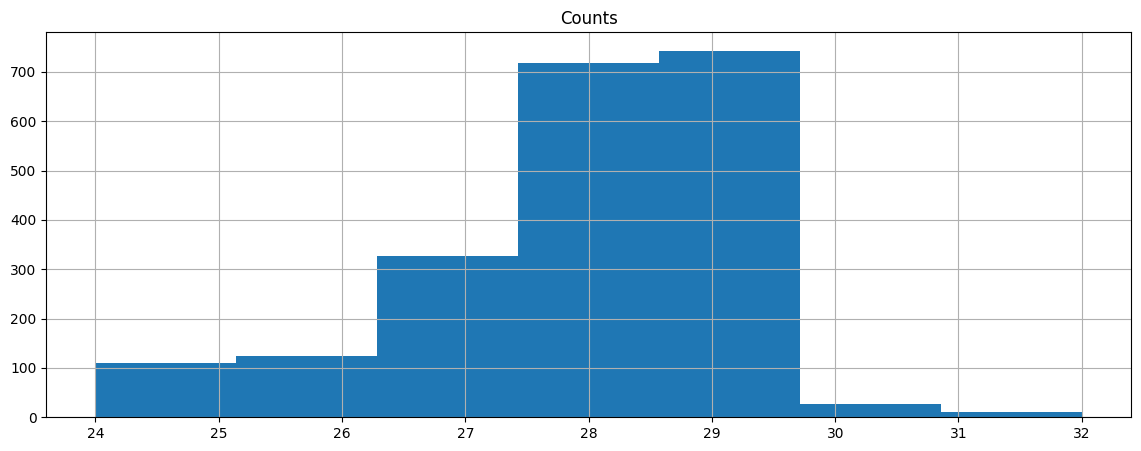

In [119]:
counts = [v.shape[0] for v in ev_x]
print(len(counts))
print(max(counts))
pd.DataFrame(counts, columns=['Counts']).hist(figsize=(14, 5), bins=7, )

In [121]:
data_x = ev_x + nf_x
data_y = ev_y + nf_y

# timestep_len = max(len(seq) for seq in data_x) # Determine the maximum sequence length
timestep_len = 24
data_x_pre = sequence.pad_sequences(data_x, maxlen=timestep_len, dtype='float64', padding='pre', truncating='pre')
data_y_pre = sequence.pad_sequences(data_y, maxlen=timestep_len, dtype='float64', padding='pre', truncating='pre')
data_x_post = sequence.pad_sequences(data_x, maxlen=timestep_len, dtype='float64', padding='post', truncating='post')
data_y_post = sequence.pad_sequences(data_y, maxlen=timestep_len, dtype='float64', padding='post', truncating='post')
# print(data_y_pre[0])
# print(data_y_post[0])
data_x = np.concatenate((data_x_pre, data_x_post), axis=0)
data_y = np.concatenate((data_y_pre, data_y_post), axis=0)

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=42)
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


x_train (6174, 24, 12)
x_test (2058, 24, 12)
y_train (6174, 24, 3)
y_test (2058, 24, 3)


In [122]:
def plot_training_history(history):
    # Extract the accuracy and loss from the history object
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [124]:
def LSTM_Model(features, targets, timesteps):
  targets = int(targets)
  print(features, targets, timesteps)
  model = Sequential()
  # model.add(layers.Masking(mask_value=0, input_shape=(timesteps, features)))
  # model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(timesteps, features)))
  # model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.LSTM(128, return_sequences=True))
  model.add(layers.TimeDistributed(layers.Dense(targets, activation='softmax')))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
  model.summary()
  return model

# def LSTM_Model(features, targets, timesteps):
#   model = Sequential()
#   model.add(layers.Masking(mask_value=0, input_shape=(timesteps, features)))
#   model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
#   model.add(layers.MaxPooling1D(pool_size=2))
#   model.add(layers.LSTM(256, return_sequences=False))
#   model.add(layers.Dense(128))
#   model.add(layers.Dense(timesteps * targets))
#   model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#   model.summary()
#   return model

In [125]:
lstm_model = LSTM_Model(x_train[0].shape[1], y_train[0].shape[1], timestep_len)


12 3 24


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [126]:
lstm_train = lstm_model.fit(x_train, y_train, shuffle=True, epochs=250, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5579 - loss: 0.1913 - val_accuracy: 0.6018 - val_loss: 0.1815
Epoch 2/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6125 - loss: 0.1764 - val_accuracy: 0.6017 - val_loss: 0.1788
Epoch 3/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6065 - loss: 0.1755 - val_accuracy: 0.6020 - val_loss: 0.1760
Epoch 4/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6062 - loss: 0.1739 - val_accuracy: 0.6037 - val_loss: 0.1731
Epoch 5/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5980 - loss: 0.1721 - val_accuracy: 0.6003 - val_loss: 0.1712
Epoch 6/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5962 - loss: 0.1682 - val_accuracy: 0.6057 - val_loss: 0.1568
Epoch 7/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6158 - loss: 0.1537 - val_accuracy: 0.6052 - val_loss: 0.1534
Epoch 8/250
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6175 - loss: 0.1518 - 

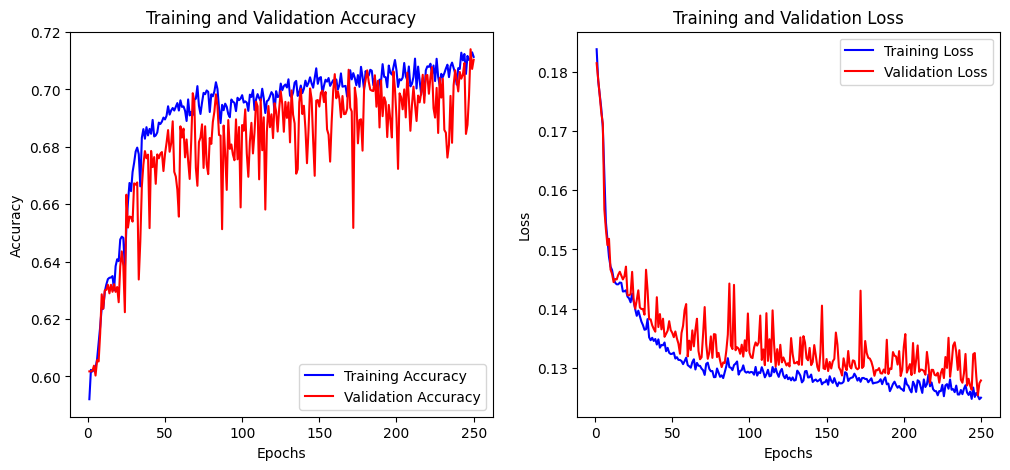

In [127]:
plot_training_history(lstm_train.history)


In [131]:
test = x_test[1].reshape(1, 24, 12)
print(test)
print(y_test[1])
print(lstm_model(test))

[[[ 8.23000000e+01  1.00000000e+00  1.06000000e+00  1.90000000e+02
    1.00000000e+00  1.00000000e+00 -3.75365737e+01 -5.92882484e+01
    1.60000000e+00  1.09000000e-01  6.00000000e+00  1.00400000e+03]
  [ 8.49000000e+01  1.00000000e+00  1.44000000e+00  1.90000000e+02
    1.00000000e+00  1.00000000e+00 -3.75367379e+01 -5.92880994e+01
    1.70000000e+00  1.65000000e-01  6.00000000e+00  9.41000000e+02]
  [ 8.73000000e+01  1.00000000e+00  1.28000000e+00  1.90000000e+02
    1.00000000e+00  1.00000000e+00 -3.75369011e+01 -5.92879462e+01
    1.70000000e+00  1.38000000e-01  6.00000000e+00  1.05900000e+03]
  [ 8.98000000e+01  1.00000000e+00  1.40000000e+00  1.90000000e+02
    1.00000000e+00  1.00000000e+00 -3.75370763e+01 -5.92878036e+01
    1.70000000e+00  1.50000000e-01  6.00000000e+00  9.92000000e+02]
  [ 9.21000000e+01  1.00000000e+00  1.38000000e+00  1.90000000e+02
    1.00000000e+00  1.00000000e+00 -3.75372457e+01 -5.92876760e+01
    1.70000000e+00  1.42000000e-01  6.00000000e+00  9.5800